# Anysee Tutorial - Face Detection / Recognition basic API usages

In this example we will first show how to use the Face Detection API to detect faces of images on the internet.
<img src="face_detection_example_01.png" alt="sample" width="200"/>

We will need a JCV Cloud API key, so be sure to have one. Refer to this [step-by-step guide](https://github.com/japancv/JCV-Cloud-Face-Recognition/blob/main/docs/QuickStart_Anysee.md) to obtain a free-to-use JCV Cloud API key in 5 minutes.

In [88]:
import base64
import logging
import requests
from requests.structures import CaseInsensitiveDict

region = 'ap-northeast-1' # this is the region we picked when we created the instance
endpoint = 'api/v1/entities/faces/detect'

url = f'https://anysee.{region}.cloud.japancv.co.jp/{endpoint}'
apikey = 'your-api-key'
headers = CaseInsensitiveDict()
headers['Content-Type'] = 'application/json'
headers['api-key'] = apikey

Here we have the REST request body for doing the detection. See the [docs](https://docs.cloud.japancv.co.jp/docs/anysee-introduction) for more information. 

For the parameters, img is the image in base64 format.

`pos` stands for the position, `ang` stands for angle, `lnd` stands for landmark locations, `qua` stands for the quality of the face, and `att` stands for the attributes.

The Json body looks like this:
```
{
    // Two different models available: JCV_FACE_K25000 or JCV_FACE_J10000
    "model": "JCV_FACE_K25000", 
    "image": {
        "data": "BASE64_ENCODED_IMAGE", // Image to detect in base64 encoding
        "area": {               // Area of interest
            "top": 0,
            "left": 0,
            "width": 1000,
            "height": 1000
        },
        "autoRotate": true,     // automatically checks four orientations of the image
        "returnDetails": {      // Whether to return the following details
            "position": true,
            "angle": true,
            "landmarks": true,
            "quality": true,
            "attributes": true
        }
    }
}
```

In [89]:
def sendRequest(img:str, pos=False, ang=False, lnd=False, qua=False, att=False):
    data = {}
    image = {}
    rd = {}
    rd["position"] = pos
    rd["angle"] = ang
    rd["landmarks"] = lnd
    rd["quality"] = qua
    rd["attributes"] = att
    image['data'] = img
    image['autoRotate'] = True
    image['returnDetails'] = rd
    data['model'] = 'JCV_FACE_K25000'
    data['image'] = image
    success = True
    try:
        res = requests.post(url, json=data, headers=headers, timeout=10)
    except Exception as e:
        logging.warning(f'Anysee timeout! {e}')
        res = 'Anysee endpoint timeout'
        success = False
    if res == 'Anysee endpoint timeout' or res.status_code != 200:
        success = False
    return res, success

The API requires a base64 format of the image data, so let's make a function to convert the data to base64 format.

In [90]:
def b64(image_path):
    with open(image_path, "rb") as image_file:
        encode = base64.b64encode(image_file.read()).decode('utf-8')
    return encode

We are going to download an image from the internet and save it for the demo. Feel free to change the image used here. We'll read it in again later.

<img src="sample.jpg" alt="sample" width="200"/>

In [91]:
img_data = requests.get('https://img.kyodonews.net/english/public/images/posts/ed58f81ded6f4ac7f66e61fed97fbe39/photo_l.jpg').content
with open('sample.jpg', 'wb') as handler:
    handler.write(img_data)

Now that we have the example image that we need, let's start doing some face detection!

It is as easy as read the image in and send the request. 

In [92]:
req_img = b64('sample.jpg')
res, suc = sendRequest(req_img, pos=True, ang=True, lnd=True, qua=True, att=True)

In [93]:
# Print part of the result out for checking
if suc:
    obj = res.json()
    print(obj['entities'][0]['details']['position'])

{'top': 364, 'left': 290, 'width': 377, 'height': 394}


In [94]:
# Here are all the responce fields
model_name = obj['model']
num_face_detected = obj['count']
faces_detected = obj['entities']
rotated = [face['rotated'] for face in faces_detected] # whether the image is rotated 90 degrees
face_details = [face['details'] for face in faces_detected]
positions = [face['position'] for face in face_details]
orientation = [face['angle'] for face in face_details]
landmarks = [face['landmarks'] for face in face_details] # 106 point face landmarks
quality = [face['quality'] for face in face_details] # quality of the face image
attributes = [face['attributes'] for face in face_details] # attributes detected on the face

Parse the attributes of all faces detected

The attribute response will look like this: 

<code style="font-size: 12px;">  

[{
  
  'age': {'value': 55, 'upperLimit': 60, 'lowerLimit': 50},

  'gender': {'value': 'male', 'certainty': 0.9999485611915588},

  'bangs': {'value': 'without_bangs', 'certainty': 0.9999999403953552},
  
  'facialHair': {'value': 'without_facial_hair',
  
   'certainty': 0.9992849826812744},

  'helmet': {'value': 'without_helmet', 'certainty': 0.9997546076774597},

  'hat': {'value': 'without_hat', 'certainty': 0.9999709129333496},

  'headphones': {'value': 'without_headphones',

   'certainty': 0.9999291300773621},

  'glasses': {'value': 'with_transparent_glasses',

   'certainty': 0.9908433556556702},

  'mask': {'value': 'without_mask', 'certainty': 0.9997501373291016},

  'emotions':[  {'value': 'angry', 'certainty': 0.00011262675980105996},

                  {'value': 'happy', 'certainty': 0.0004005885566584766},
                  {'value': 'sad', 'certainty': 0.0003769049944821745},
                  {'value': 'calm', 'certainty': 0.9990901947021484},
                  {'value': 'surprised', 'certainty': 1.4780510355194565e-05},
                  {'value': 'scared', 'certainty': 2.091303258566768e-06},
                  {'value': 'disgusted', 'certainty': 2.056159331687013e-07},
                  {'value': 'sleepy', 'certainty': 2.5625081434554886e-06}
               ]
                
  }]

</code>

In [95]:
age         = [attr['age']['value'] for attr in attributes]
gender      = [attr['gender']['value'] for attr in attributes]
bangs       = [attr['bangs']['value'] for attr in attributes]
facial_hair = [attr['facialHair']['value'] for attr in attributes]
helmet      = [attr['helmet']['value'] for attr in attributes]
hat         = [attr['hat']['value'] for attr in attributes]
headphones  = [attr['headphones']['value'] for attr in attributes]
glasses     = [attr['glasses']['value'] for attr in attributes]
mask        = [attr['mask']['value'] for attr in attributes]
emotions    = [sorted(attr['emotions'], key=lambda x: x['certainty'], reverse=True)[0]['value'] for attr in attributes]

Write a draw function for verifying the results 

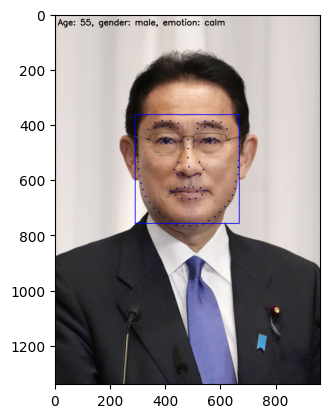

In [98]:
import cv2
from matplotlib import pyplot as plt
DRAW_LANDMARKS = True # false if you want to see the effect without landmarks
img = cv2.imread('sample.jpg') # read the image in

for i in range(num_face_detected):
    pos = positions[i] # draw face detection
    img = cv2.rectangle(img, (pos['left'], pos['top']), (pos['left'] + pos['width'], pos['top'] + pos['height']), (255,0,0), 2)    

    text = f'Age: {age[i]}, gender: {gender[i]}, emotion: {emotions[i]}'
    img = cv2.putText(img, text, (10, 40 * (i+1)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2, cv2.LINE_AA)

    if DRAW_LANDMARKS:
        lmd = landmarks[i] # draw face landmarks
        for pt in lmd:
            img = cv2.circle(img, (pt['x'], pt['y']), 1, (127,0,0) ,2)  
img = img[:,:,::-1] # transform image from BGR to RGB
plt.imshow(img)
plt.show()



Challange: This pipeline supports image with multiple faces. Try it yourself with an image with more faces!

(Here's one if you need it: https://alexis.lindaikejisblog.com/photos/shares/images.jpeg-2_1688932396.jpg)